# PyTorch - Classification - 1
 >__Created__: October 2019, Bari, Italy
 

## Introduction
We consider the benchmark task of classifying the $28 \times 28 = 784$ gray scale pixel images of handwritten digits in the [MNIST](http://yann.lecun.com/exdb/mnist) data set using __supervised learning__. In supervised learning a model is trained (that is, fitted) to data consisting of unambiguously labeled __feature vectors__, here images. For classification, the label is the class to which a vector belongs, while for regression the labels are the values associated with the vectors. In the MNIST data set there are $K = 10$ classes, labeled by the digits 0 to 9. The data contains $T = 60,000$ images for training and 10,000 images for testing. Following good practice, we split the training data into a set for training and another for validating the training. The test data are not used in the training.

The value of each pixel in the MNIST data set lies in the discrete set $[0, 1, \cdots, 255]$. Again, following good practice, we rescale each datum so that it lies in the unit interval. In this exercise, the data lie in the (rational) set $D = [0, 1/255, \cdots, 1]$. The MNIST training data may be viewed as a sample from an unknown probability distribution $p(t, x)$ defined on the finite discrete space $[0,\cdots,9] \times D^{784}$, where the __target__, $t$, is the class label associated with image $x$. ($p(t, x)$ is clearly an abstraction since it is the distribution of an *infinite* MNIST data set that exists only in the same sense as the set of real numbers.) An image is then a point $x \in D^{784}$. If we associate each class with a different color, the training data form a swarm of colored points where points of a given color tend to "flock" together in the space $D^{784}$.

In this exercise, a fully connected shallow neural network (SNN) is used to classify the MNIST digits. The training is done with __batches__ of images represented by a 2-index tensor $\mathbf{x}_{nj}$ of __shape__ $(N, H \times W)$, i.e., a matrix. The first index (along dimension dim = 0) labels the ordinal value $n$ of an image in a batch of $N$ images, while the second index (along dim = 1) labels the pixels of a *flattened* image of height and width $H$ and $W$, respectively.  

### Model
Machine learning models often have an aura of mystery about them. But, a sensible perspective can be maintained by remembering that regardless of how their form may have been motivated, these models are, ultimately, just exceedingly complicated non-linear functions. 

Another point should be noted before we delve into details. Much has been made of the sometimes spectacular failure in the application of machine learning to real-world problems. For example, suppose that a single pixel in an image is changed, say from the value 197/255 to the value 0. This causes the point representing the image in the space $D^{784}$ to suffer a displacement in that space. To the human brain, a single pixel change in a $28 \times 28$ image is a negligible distortion that does not impair its ability to classify the image, either because the distortion goes unnoticed or it is ignored. But, to a machine learned classifier, a single pixel change could result in a large displacement in the abstract space of images, thereby making the image an outlier whose position is no longer representative of the distribution of *any* of the classes defined by the probability $p(t, x)$. The point is that the classifier depends on the probability $p(t, x)$, therefore, if the latter fails to capture the kinds of outliers one expects in real-world data, it ought not to surprise that the classifier may fail to classify an outlier correctly. 

One might think that the solution is to train with data that contains outliers. However, it may not be feasible to build a model that captures every sort of potential outlier. Moreover, if outliers in the training data are relatively rare, the training procedure may simply ignore them. A more practical approach might be to devise a way to recognize when an image is an outlier, detect which subsets of pixels are responsible for this and assign to the offending pixels values that are representative of their neighborhood. Having tamed the image in this way, it is then presented to the classifier.

In this exercise, we use the following model 

$$\mathbf{y} = \mbox{softmax}(\,\mathbf{b}_1 + \mathbf{w}_1 \, \mbox{relu}(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}) \, ),$$

where $\mathbf{b}$ and $\mathbf{w}$, the biases and weights, are the parameters of the model and $\mbox{relu}(x)$, which is a function applied to every element $x$ of its tensor argument (i.e., applied element-wise), is defined by

\begin{align*}
\mbox{relu}(x) & = \begin{cases}
    x, & \text{if } x \gt 0\\
    0              & \text{otherwise}.
\end{cases}
\end{align*}

The parameters with suffix 0 pertain to the input layer, while those with suffix 1 pertain to the so-called __hidden__ layer.
Since $\mathbf{y}$ models class probabilities that sum to unity, it makes sense to map each output of the hidden layer to the unit interval by applying, for example, the softmax function for $K$ output classes, 

\begin{align*}
(\mbox{softmax}(x))_k & = \frac{\exp(x_{(k)})}{\sum_{j=0}^{K-1} \exp(x_{(j)})} ,
\end{align*}

where $x_{(k)}$ denotes the $k^\mbox{th}$ output of the hidden layer. 

### Loss function
Typically, a machine learning model is fitted to the training data by minimizing a suitably defined function, which in the statistics literature is often referred to as the __empirical risk__. (Fitting models to data is called learning by machine learning enthusiasts.) The empirical risk is a Monte Carlo approximation of the __risk functional__, defined by 

\begin{align*}
    R[f] &= \int L(t, \, f(x, \theta)) \, 
    p(t, \, x) \, dt \, dx,
\end{align*}

where $L(t, \, f)$ is called the __loss function__ and measures how much one loses if the output of the parameterized function $f(x, \theta)$ differs from the __target__ $t$. $\color{blue}{\rm Warning}$: In the machine learning world, the empirical risk is typicaly referred to as the loss function, when what is really meant is the average loss function. 

__Important Note__: In order for the risk functional $R[f]$ to reach its minimum, defined by variations of $f$ that yield the condition $\delta R = 0$ for all $x$, the function $f$ must be sufficiently flexible. If the latter condition is satisfied, then the mathematical quantity approximated by $f$ depends solely on the form of the loss function $L(t, \, f)$ and the probability distribution $p(t, \, x)$ of the training data. In particular, it does not depend on
    the details of the functon $f$ apart from its presumed flexibility. Of course, in practice, we do not minimize $R[f]$, but rather the empirical risk, which approximates it. Nevertheless, to the degree that a very large data set approximates an infinite one and to the degree that our minimizer is able to find a good approximation to the minimum, this bit of reasoning suggests that it is as least as important to think about the form of the loss function $L(t, \, f)$ as it is to think about the form of the model. If we have two models of equal functional flexibility then, *a priori*, for the same loss function the models will approximate the same quantity. 

In order to motivate our choice of loss function, we start with the __Kullback-Leibler__ (KL) divergence

\begin{align*}
    D(p || q) & = \sum_i p_i \log(p_i / q_i),
\end{align*}

which is a *global* measure of the dissimilarity between a probability distribution $p$ and a reference distribution $q$. The KL divergence is a global measure in that it depends on the entire probability distributions $p$ and $q$. In particular, the measure does not supply information about where $p$ and $q$ are well matched and where they are not. 

The KL divergence is zero if and only if the two distributions are identical. Typically, we have a model for $q$, but $p$ is usually unknown, which makes it difficult to approximate $D(p || q)$. However, the KL divergence can be written as,

\begin{align*}
  D(p || q) & = \sum_i p_i \log(p_i / q_i),\\
            & = -\sum_i p_i \log q_i - \left(-\sum_i p_i \log p_i\right),\\
            & = H(p, q) - H(p).
\end{align*}

The quantity $H(p) = -\sum_i p_i \log p_i$ is called the __entropy__, while $H(p, q)$ is called the __cross entropy__. Like the KL divergence, the cross entropy is minimized when $q = p$, whereupon it equals the entropy of the probability distribution $p$. The practical advantage of the cross entropy over the KL divergence is that for training data distributed according to $p$, we can use the following Monte Carlo approximation of the cross entropy,

\begin{align*}
  H(p, q) & = -\sum_i p_i \log q_i,\\
            & \approx -\frac{1}{T}\sum_{i=0}^{T-1} \log q_i,
\end{align*}

where $T$ is the number of feature vectors, here images, in the training set. In this exercise, we shall use cross entropy as the loss function.
The outputs of the model are the conditional class probabilities

\begin{align*}
    P(k \, | \, \mathbf{x} ) & = \frac{P(\mathbf{x} \, | \, k) \, \pi(k)}{\sum_{j=0}^K P(\mathbf{x} \, | \, j) \, \pi(j)},
\end{align*}

where $\pi(k)$ is the prior probability of class $k$ and $P(\mathbf{x} \, | \, k)$ is the probability of image $\mathbf{x}$ *given* that it is of class $k$. ($P(\mathbf{x} \, | \, k)$ is often referred to as the __likelihood__.) To compute the loss function, we set $q_i = P(k_i \, | \, \mathbf{x}_i )$, where $k_i$ is the true class index of image $x_i$. In other words, we take $q_i$ to be the estimated conditional probability that image $x_i$ is of class $k_i$ given that it is known to be of that class.

In [1]:
import os, sys

# the standard module for tabular data
import pandas as pd

# the standard module for array manipulation
import numpy as np

# the standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl
import imageio as im

#  a function to save results
import joblib as jb

# pytorch
import torch

# pytorch's automatic differentiation 
from torch.autograd import Variable

%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load Images
If the files are do not exist, go to the __datasets__ folder and run the notebook __prepare_mnist_data.ipynb__ to create them.

In [3]:
train_x, train_y = jb.load('../datasets/mnist_train.pkl')
test_x,  test_y  = jb.load('../datasets/mnist_test.pkl')

### Plot first few  images
Use imshow(..) and show() to display the image.

In [4]:
def plotImages(x, n_rows=2, n_cols=5, f_size=(10, 4)):
    f, ax = plt.subplots(nrows=n_rows, 
                         ncols=n_cols, 
                         figsize=f_size)
    # note use of flatten() to convert a matrix of shape (nrows, ncols)
    # to a 1-d array.
    for image, ax in zip(x, ax.flatten()):
        ax.imshow(image.reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

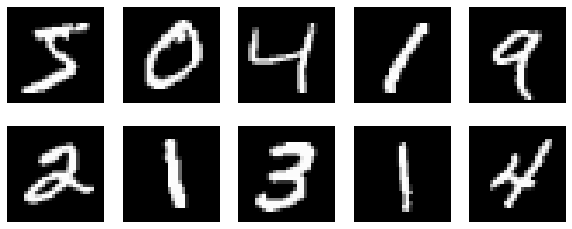

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [5]:
plotImages(train_x)
train_y[:10]

### Prepare training and validation sets

In [7]:
n_iter   = 10000       # number of iterations
n_batch  = 128         # N = n_batch
learning_rate  = 1.e-3
train_fraction = 0.7   # fraction of data used for training


M = int(train_fraction*len(train_x))
train_x, val_x = train_x[:M], train_x[M:]
train_y, val_y = train_y[:M], train_y[M:]

n_train = len(train_x)
n_valid = len(val_x)
n_test  = len(test_x)

print("number of images for training:   %10d" % n_train)
print("number of images for validation: %10d" % n_valid)
print("number of images for testing:    %10d" % n_test)

number of images for training:        42000
number of images for validation:      18000
number of images for testing:         10000


### Define model

Use some magic to write the following cell to the file __SNN.py__, which can then be imported into another notebook. But, it seems we need to import the saved
class back into this notebook.

In [8]:
val_y[:5]

array([1, 2, 1, 8, 7])

In [8]:
%%writefile SNN.py
# A fully connected shallow neural network
import torch.nn as nn
import torch.nn.functional as F

class SNN(nn.Module):
    
    def __init__(self):
        """
    A fully-connected shallow neural network, that is, one with a
    single hidden layer.
        """ 
        # call constructor of base (or super, or parent) class
        super(SNN, self).__init__()
        
        # INTRODUCTION
        # linear model:   a model of the form y = b + w*x
        # feature:        an attribute, e.g., a pixel value
        # feature vector: an ordered list of features, e.g., an image
        #
        # The function nn.Linear(inputs, outputs)
        # computes
        #   y = b + w*x
        # where x is a tensor of shape (number, inputs), w a tensor of
        # shape (outputs, inputs), b a tensor of shape (outputs) and
        # y is a tensor of shape (number, outputs).
        #   number:  the batch size, that is, the number of feature 
        #            vectors used to compute the average loss, which, in
        #            turn, is used to compute the local gradient in 
        #            a minimization step.
        #   inputs:  the number of features/feature vector
        #   outputs: the number of outputs of the linear model.
        #
        # DETAILS
        # The first linear model has 784 inputs and 2500 outputs, 
        # followed by another linear model with 2500 inputs and 
        # 10 outputs. 
        #
        # There are 784 * 2500 weights + 2500 biases in the first linear
        # model. The linear model (the second layer) has 2500 * 10 
        # weights + 10 biases. Therefore, the total number of parameters 
        # in this network is 
        # 784 * 2500 + 2500 + 2500 * 10 + 10 = 1,987,510, that is, about
        # 2 million!
        self.layer0 = nn.Linear(784, 2500)
        self.layer1 = nn.Linear(2500,  10) # the "hidden" layer.
        
    def __str__(self):
        s = ''
        for layer in [self.layer0, 
                      self.layer1]:
            s += '%s\n' % layer
        return s
    
    # this required method computes the output of the network
    def forward(self, x):
        """
        x:  input data (of type Variable) 
        """
        # compute y = relu(b0 + w0*x) element-wise
        y = F.relu(self.layer0(x))
        
        # during training, randomly dropout, that is, set to zero, 
        # half of the elements in the input tensor y. dropout has
        # been shown to improve the training and yield better results.
        y = F.dropout(y, p=0.5, training=self.training)
               
        # estimated class probabilities for ith feature vector, here an
        # image,
        #   q_i(k) = exp(y_i(k) / sum_j exp(y_i(j)), j = 0,..., K-1,
        # where K=10 is the number of classes and y_i(k) is the output 
        # for the ith feature vector for class index k. 
        # apply the softmax function horizontally, i.e., along 
        # the class axis (dim=1)
        # (dim=0 is vertical, that is, along the batch axis.)
 
        y = F.softmax(self.layer1(y), dim=1)

        return y

Overwriting SNN.py


### Create an instance of the model
Note the import of the class that we've just saved.

In [9]:
from SNN import SNN
model = SNN()
model

SNN(
  (layer0): Linear(in_features=784, out_features=2500, bias=True)
  (layer1): Linear(in_features=2500, out_features=10, bias=True)
)

### Define average loss (or empirical risk) function
Here we use the cross-entropy,
\begin{align*}
  H(p, q) & = -\sum_i p_i \log q_i,\\
            & \approx -\frac{1}{T}\sum_{i=0}^{T-1} \log q_i.
\end{align*}

In principle, we want $T \rightarrow \infty$, but, in practice, $T = batch\_size$. This is done to produce a noisy approximation of
the cross-entropy and therefore a noisy approximation of the local
gradient. The stochasticity introduced increases the probability that the minimizer won't get stuck in a local minimum that is a poor approximation to the global minimum.

In [12]:
class AverageLoss():
    def __init__(self):
        pass
    
    def __call__(self, outputs, targets):
        """
    Compute the cross entropy defined by
        H(p, q) = -sum_i p_i log(q_i),
                = -(1 / T) sum_i=0^T-1 log(q_i)
 
    which is minimized when the estimated probability q_i for the
    ith feature vector matches the true probability p_i.
 
    outputs: estimated class probabilities
             shape: (batch_size, number_classes) 
    targets: class indices [0,...,K-1], shape: (batch_size, ) 
        """
        # For each feature vector i, pick the estimated probability q_i
        # that corresponds to its true class index. The true class 
        # indices for the feature vectors (the images) are given in 
        # targets.
        #
        # Note the very powerful numpy-like syntax for accessing 
        # specific elements of an nd-array: outputs[list1, list2].
        # basically, for each row i we pick the value in the column 
        # number given in target[i]. 
        # Note also: range(batch_size) is [0,...batch_size-1].
        batch_size = len(outputs)
        outputs = outputs[range(batch_size), targets]
        
        # compute H(p, q) = -sum_i p_i log(q_i)
        return -torch.sum(torch.log(outputs)) / batch_size 

In [13]:
avloss = AverageLoss()

### Get batch
Get a random sample from the training set of size $n\_batch$

In [21]:
def randomBatch(train_x, train_y, batch_size):
    # the numpy function choice(length, number)
    # selects at random "number" integers from the range [0, length-1]
    rows    = rnd.choice(len(train_x), batch_size)
    batch_x = train_x[rows]
    batch_y = train_y[rows]
    return (batch_x, batch_y)

### Accuracy
Compute fraction of correct predictions.

In [14]:
def accuracy(outputs, targets):
    # We take the ordinal value of the highest of the 10 outputs as the
    # predicted class index. Use the numpy function argmax to do this.
    #
    # argmax scans the numpy array along the specified axis, here the 
    # horizontal axis (axis=1), which is in the class direction, and 
    # returns the ordinal value of the maximum value along that axis, 
    # which will be the predicted class index.
    #
    # Note the required use of data.numpy() to return the tensor outputs 
    # as a numpy array, which is the argument type expected by argmax.
    outputs = np.argmax(outputs.data.numpy(), axis=1)
    
    # Count how many times the predicted class index matches the true 
    # class index of the image and convert to a fraction.
    return float(np.sum(outputs==targets.data.numpy())) / len(targets)

### Trainer

In [19]:
def train(model, optimizer, avloss, train_x, train_y, batch_size):
    # set mode to training so that training specific operations such 
    # as dropout are enabled.
    model.train()
    
    # Get a random sample (a batch) of images
    batch_x, batch_y = randomBatch(train_x, train_y, batch_size)
        
    # Convert the numpy arrays batch_x and batch_y, the images and 
    # class indices, respectively, to tensor types and then to Variable
    # types. The later is the expected type into models and the loss
    # functions (really average loss or empirical risk functions).
    #
    # The type Variable is the magic that permits automatic 
    # differentiation with respect to its arguments. However, we do not
    # need this feature for the images and the class indices, so we
    # disable it.
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        x = Variable(torch.from_numpy(batch_x))
        y = Variable(torch.from_numpy(batch_y))       

    # compute the output of the model for the batch of images x
    outputs = model(x)
    
    # compute a noisy approximation to the average loss
    loss    = avloss(outputs, y)
    
    # use automatic differentiation to compute a noisy approximation
    # of local gradient
    optimizer.zero_grad()  # clear previous gradients
    loss.backward()        # compute gradients
    
    # Finally, advance one step in the direction of steepest descent,
    # using the noisy local gradient. Consider a 2-million dimensional 
    # hyper-surface defined by the average loss in the limit of an 
    # infinite training sample. In principle, that is the hyper-surface 
    # we really wish we could explore and whose global minimum we would
    # like to find. But, since this is impossible, we instead construct
    # at any given point on this hyper-surface a noisy approximation 
    # to it using the loss function averaged over a small batch of images. 
    # Then, we approximate the local gradient using the noisy local
    # approximation to the hyper-surface. Necessarily, the gradient 
    # will be a noisy approximation to the ideal, or true, local gradient. 
    #
    # This may seem like an odd thing to do. Surely, it is better to 
    # use as large a training sample as possible in order to provide a 
    # more accurate approximation to the hyper-surface at any given
    # point? However, that is actually a bad idea! Firstly, using the 
    # full training sample to define the average loss would drastically 
    # slow down the minimization. Secondly, the hyper-surface is likely
    # to be highly corrugated with a huge number of local minima. 
    # Gradient descent in such a landscape runs the risk that a minimizer
    # could fall into a local minimum and stay there. If the local
    # minimum is close to the global mininum there is no issue. But it
    # would be an issue if the local minimum is far from the global 
    # minimum. 
    #
    # The use of noisy estimates of local gradients makes it possible for
    # a minimizer, just by chance, to escape from a local minimum and 
    # therefore more likely to find a local minimum closer to the global 
    # one. This idea suggests that perhaps we should begin with very 
    # noisy gradients. Then, if we notice the minimizer bouncing around 
    # neither going uphill or downhill on the average, then we could 
    # surmise that it is actually bouncing around a minimum. Of course,
    # we can never be certain that this is the global minimum, but, if it
    # is, it would make sense to gradually increase the batch size until
    # the minimizer settles down.

    optimizer.step()       # move one step
        
def validate(model, train_x, train_y, val_x, val_y):
    # make sure we set evaluation mode so that training specific
    # operations such as dropout are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # compute accuracy using training sample
        x = Variable(torch.from_numpy(train_x))
        y = Variable(torch.from_numpy(train_y))
        o = model(x)
        acc_t = accuracy(o, y)
  
        # compute accuracy using validation sample
        x = Variable(torch.from_numpy(val_x))
        y = Variable(torch.from_numpy(val_y))
        o = model(x)
        acc_v = accuracy(o, y)

    return (acc_t, acc_v)
               
def trainModel(model, optimizer, avloss, 
               train_x, train_y,
               val_x, val_y,
               n_iterations, batch_size):
    xx   = []
    yy_t = []
    yy_v = []

    for ii in range(n_iterations):
        # do one step of minimization
        train(model, optimizer, avloss, 
              train_x, train_y, 
              batch_size)

        # print out accuracies on training and validation 
        # data sets
        if   ii < 20:
            step = 1
        elif ii < 100:
            step = 10
        elif ii < 1000:
            step = 100
        else:
            step = 500
        
        if ii % step == 0:
            acc_t, acc_v = validate(model, 
                                    train_x, train_y, 
                                    val_x, val_y)
            
            print("%10d\t%10.4f\t%10.4f" % (ii, acc_t, acc_v))
        
            xx.append(ii)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
    return (xx, yy_t, yy_v)

### Choose minimizer

In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

In [22]:
xx, yy_t, yy_v = trainModel(model, optimizer, avloss,
                            train_x, train_y, 
                            val_x, val_y,
                            n_iter, n_batch)
print("done!")

         0	    0.2755	    0.2758
         1	    0.3950	    0.3969
         2	    0.4796	    0.4838
         3	    0.5853	    0.5934
         4	    0.6911	    0.7076
         5	    0.7555	    0.7697
         6	    0.7857	    0.7974
         7	    0.7915	    0.8020
         8	    0.7829	    0.7938
         9	    0.7913	    0.8007
        10	    0.8035	    0.8145
        11	    0.8086	    0.8197
        12	    0.8107	    0.8182
        13	    0.8049	    0.8119
        14	    0.8023	    0.8111
        15	    0.8061	    0.8123
        16	    0.8161	    0.8223
        17	    0.8313	    0.8392
        18	    0.8429	    0.8505
        19	    0.8512	    0.8573
        20	    0.8542	    0.8587
        30	    0.8674	    0.8712
        40	    0.8895	    0.8916
        50	    0.8945	    0.8951
        60	    0.9066	    0.9070
        70	    0.9115	    0.9107
        80	    0.9156	    0.9155
        90	    0.9122	    0.9119
       100	    0.9082	    0.9063
       200	    0.9456	    0.9428
       300

In [23]:
def plot(xx, yy_t, yy_v):
    # Note: every element in a plot is an Artist object! 
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    # adjust y limits
    axes = ax.axes
    axes.set_ylim((0.8, 1))
    axes.set_xlim((0, xx[-1]))
    
    plt.plot(xx, yy_t, 'b', label='Training')
    plt.plot(xx, yy_v, 'r', label='Validation')
    plt.title('Training and Validation Errors')
    plt.xlabel('Iterations', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.grid(True, which="both", linestyle='-')
    plt.legend(loc='lower right')
    plt.show()

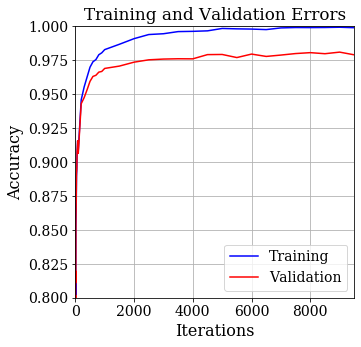

In [24]:
plot(xx, yy_t, yy_v)

### Save trained model

In [25]:
torch.save(model.state_dict(), 'mnist_model_snn.pth')

In [27]:
batch_x, batch_y = randomBatch(test_x, test_y, 10)

In [28]:
with torch.no_grad(): # no need to compute gradients wrt. x and y
    # compute accuracy using training sample
    x = Variable(torch.from_numpy(batch_x))
    y = Variable(torch.from_numpy(batch_y))
    o = model(x)

In [30]:
outputs = np.argmax(o.data.numpy(), axis=1)

In [33]:
outputs

array([5, 4, 5, 1, 9, 2, 5, 5, 5, 5])

In [34]:
y

tensor([5, 4, 5, 1, 9, 2, 5, 5, 5, 5])